In [1]:
import tests.methods.torch_nvd as nvd
import tests.methods.utils as utils

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd
import numpy as np

import pandas as pd
import networkx as nx

import scipy.stats as st

from math import comb
import seaborn as sns

# Common test variables
Run python script with variables common to all synthetic experiments, also sets random seed.

In [2]:
%run -i "test_variables.py"

# Defining variables in the notebook for code highlighting purposes
metrics = metrics
local_tests = local_tests
local_num_nodes_range = local_num_nodes_range
random_run_metrics = random_run_metrics
mds_runs = mds_runs
SBM_runs = SBM_runs
node_size = node_size
edge_color = edge_color
local_edge_width = local_edge_width
local_edge_alpha = local_edge_alpha
global_edge_width = global_edge_width
global_edge_alpha = global_edge_alpha
labelpad=labelpad
fontsize=fontsize

In [3]:
# palette_tab10 = sns.color_palette("tab10", 10)
# blue = palette_tab10[0]
# red = palette_tab10[3]

# colors = [blue, '#d9d2dd', red]
# sns.blend_palette(colors, n_colors=len(colors), as_cmap=True)

# Interpreting neutral nodes as new opinion

In [4]:
experiment_folder = 'neutral_to_orthog_nodes/'

### Local Setup

In [5]:
comms = 3  # Number of communities in the local community network

num_nodes = 12
x_range = ['Neutral', 'Orthogonal']

Figure saved


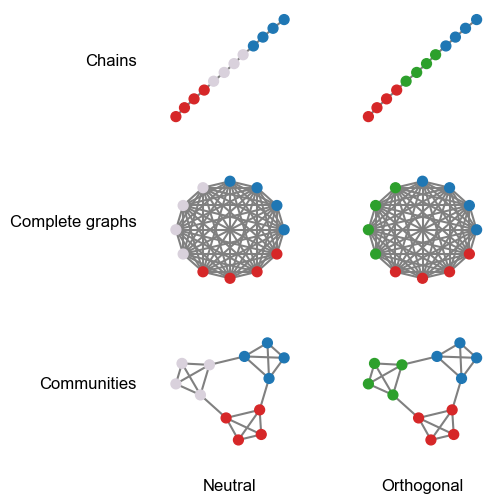

In [6]:
fig, ax = plt.subplots(3, len(x_range), figsize=(2*len(x_range), 5))
fig.tight_layout()

for test_index, (name, graph_gen) in enumerate(local_tests):
    ax[test_index, 0].set_ylabel(name, rotation=0, labelpad=20, fontsize=12, ha='right')
 
    for x_index, opinion_type in enumerate(x_range):

        nodes_per_comm = num_nodes // comms

        if graph_gen == utils.make_community_graph:
            G = graph_gen(comms, nodes_per_comm)
        else:
            G = graph_gen(num_nodes)
        
        pos = nx.kamada_kawai_layout(G) # seed=1, k=10, iterations=1000

        # hide subplot axes lines
        for direction in ['top','right','left','bottom']:
            ax[test_index, x_index].spines[direction].set_visible(False)

        
        if x_index == 0:
            cmap = utils.cmap('br')
            node_colors = [0] * nodes_per_comm + [1] * nodes_per_comm + [2] * nodes_per_comm
        else:
            cmap = utils.cmap('bgr')
            node_colors = [0] * nodes_per_comm + [1] * nodes_per_comm + [2] * nodes_per_comm
        
        nx.draw_networkx_nodes(G, ax=ax[test_index, x_index], pos=pos, node_size=node_size, cmap=cmap, node_color=node_colors)
        nx.draw_networkx_edges(G, ax=ax[test_index, x_index], edge_color='gray', pos=pos, width=local_edge_width)
        
        # set opinion_type as x-axis label
        ax[2, x_index].set_xlabel(opinion_type, fontsize=fontsize, labelpad=labelpad)

utils.save_figure("local_setup", experiment_folder, overwrite=False)

### Local Results

D:\OneDrive\ITU\Bachelor's Project\Quantifying-Multipolar-Polarization\tests\methods\torch_nvd.py:84: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  diff_T = diff.T


Figure saved


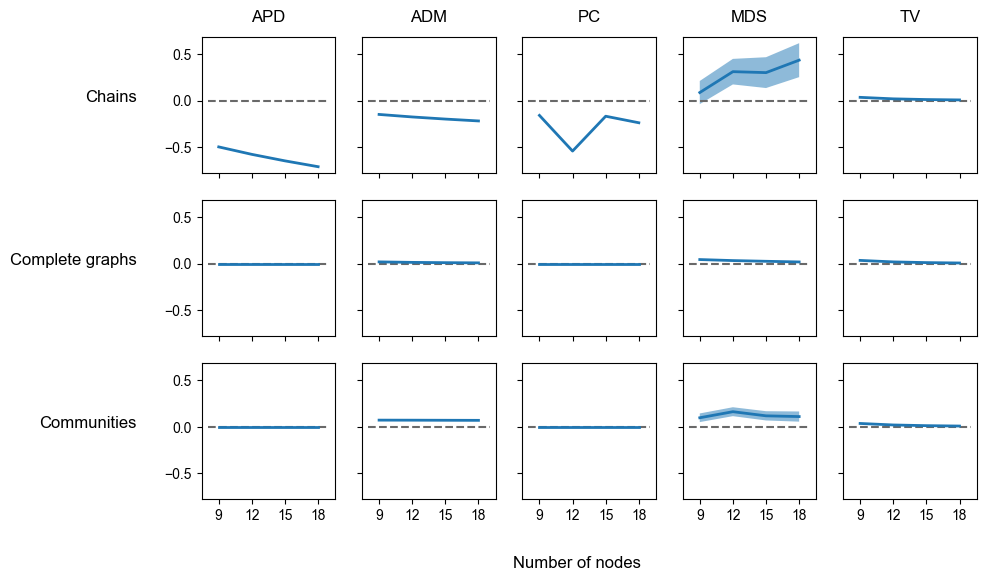

In [7]:
num_nodes_range = range(9, 19, 3)

fig, ax = plt.subplots(len(local_tests), len(metrics), figsize=(len(metrics)*2, len(local_tests)*2), sharey=True, sharex=True)

# Set ticks for all x axes (since they are shared)
ax[0, 0].set_xticks(num_nodes_range)

# Set limits for all y axes (since they are shared)
# ax[0, 0].set_ylim(-4, 4)

for test_index, (graph_name, graph_type) in enumerate(local_tests):

    for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

        # Initialize arrays to store the means and confidence intervals of repeated runs
        means = np.zeros(len(num_nodes_range))
        lower_confs = np.zeros(len(num_nodes_range))
        higher_confs = np.zeros(len(num_nodes_range))

        for opinion_index, num_nodes in enumerate(num_nodes_range):

            nodes_per_comm = num_nodes // comms

            run_pols = np.zeros(mds_runs)

            for run in range(mds_runs):
            
                if graph_type == utils.make_community_graph:
                    G = graph_type(n_comms=comms, nodes_per_comm=nodes_per_comm)
                else:
                    G = graph_type(num_nodes)
                    # print(f"num_nodes: {num_nodes}, run: {run}")

                # neutral opinion polarization
                o = pd.DataFrame(np.vstack((np.array([(1,0)]*nodes_per_comm),
                                            np.array([(0,0)]*nodes_per_comm),
                                            np.array([(0,1)]*nodes_per_comm))))
                # print(o)
                tensor = nvd.make_tensor(G, o)
                neutral_polarization = polarization_metric(tensor)

                # third opinion polarization
                o = pd.DataFrame(np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                            np.array([(0,1,0)]*nodes_per_comm),
                                            np.array([(0,0,1)]*nodes_per_comm))))
                
                tensor = nvd.make_tensor(G, o)
                third_polarization = polarization_metric(tensor)

                difference = third_polarization - neutral_polarization
                run_pols[run] = difference

                # Only keep the first run
                if polarization_metric not in random_run_metrics:
                    run_pols = np.array([run_pols[0]])
                    break
            
            if polarization_metric in random_run_metrics:
                # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
                run_pols += np.random.normal(0, 1e-10, run_pols.size)

                # Calculate the 95% confidence intervals
                lower_conf, higher_conf = st.t.interval(0.95, run_pols.size-1, loc=np.mean(run_pols), scale=st.sem(run_pols)) # means[opinion_index]

                lower_confs[opinion_index] = lower_conf
                higher_confs[opinion_index] = higher_conf

            means[opinion_index] = np.mean(run_pols)

        if polarization_metric in random_run_metrics:
            ax[test_index, metric_index].fill_between(num_nodes_range, higher_confs, lower_confs, alpha=.5, linewidth=0)

        # Draw line at 0 for layout purposes
        ax[test_index, metric_index].hlines(0, num_nodes_range[0]-1, xmax=num_nodes_range[-1]+1, colors='dimgrey', linestyles='dashed', label='Expected')

        ax[test_index, metric_index].plot(num_nodes_range, means, lw=2)

        # Add title to the first row
        if test_index == 0:
            ax[test_index, metric_index].set_title(metric_name, fontsize=12, y=1.05, ha='center')

        # Add title to the first column
        if metric_index == 0:
            ax[test_index, metric_index].set_ylabel(graph_name, rotation=0, labelpad=20, fontsize=12, ha='right')

# fig.supylabel('Polarization', x=0.08)
fig.supxlabel('Number of nodes', fontsize=12, y=-0.01)

utils.save_figure("local_res", experiment_folder, overwrite=True)

### Global Setup

In [8]:
# Experiment variables

p_in = 0.1
p_out = 0.01
n_comms = 3
intercon = n_comms-1
nodes_per_comm = 100

In [9]:
def generate_G1_G2(n_comms, nodes_per_comm, p_in, p_out, community_labels = False, positions = False):
    
    G1 = utils.stochastic_block_model(n_comms, nodes_per_comm, p_in, p_out, community_labels, positions)

    G2 = G1.copy()

    return G1, G2

In [10]:
blue = '#1f77b4'
red = '#d62728'
green = '#2ca02c'

colors = [blue, green, red]
list(sns.blend_palette(colors, n_colors=len(colors), as_cmap=False).as_hex())

['#1f77b4', '#2da02c', '#d62728']

Figure saved


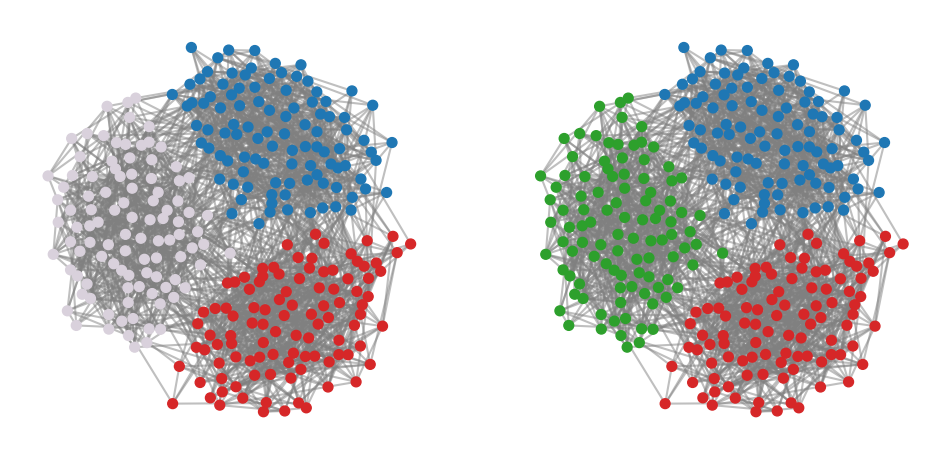

In [11]:
G1, G2 = generate_G1_G2(n_comms, nodes_per_comm, p_in, p_out, community_labels=True)

fig, ax = plt.subplots(1, 2, figsize=(2*5, 5))
for direction in ['top','right','left','bottom']:
    for axis in ax:
        axis.spines[direction].set_visible(False)
fig.tight_layout()

pos = nx.kamada_kawai_layout(G1)
node_communities = nx.get_node_attributes(G1, 'community')

for i, G in enumerate([G1, G2]):

    if i == 0:
        cmap = list(utils.cmap('br', as_colormap=False).as_hex())
    else:
        cmap = list(utils.cmap('bgr', as_colormap=False).as_hex())
    
    node_colors = [cmap[node_communities[node]] for node in G.nodes]

    nx.draw_networkx_nodes(G, ax=ax[i], pos=pos, node_size=node_size, node_color=node_colors)
    nx.draw_networkx_edges(G, ax=ax[i], edge_color='gray', pos=pos, width=local_edge_width, alpha=local_edge_alpha)

utils.save_figure("global_setup", experiment_folder, overwrite=False)

### Global Results

KeyboardInterrupt: 

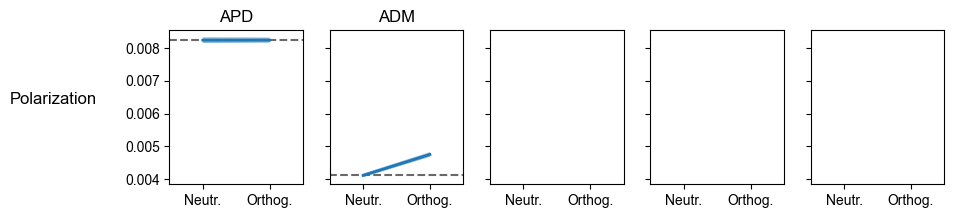

In [16]:
nodes_per_comm = 1000

x_range = [1, 2]

fig, ax = plt.subplots(1, len(metrics), figsize=(len(metrics)*2, 2), sharey=True, sharex=True)

# Set ticks for all x axes (since they are shared)
ax[0].set_xticks(x_range)
# Set xlabels for all x axes (since they are shared)
ax[0].set_xticklabels(['Neutr.', 'Orthog.'])
# Set x limits
ax[0].set_xlim(x_range[0]-0.5, x_range[-1]+0.5)

for metric_index, (metric_name, polarization_metric) in enumerate(metrics):

    if polarization_metric == nvd.MDS_manifold:
        num_runs = mds_runs
    else:
        num_runs = SBM_runs

    # initialize array for polarization values with shape (num_runs,len(x_range))
    run_pols = np.zeros((num_runs, len(x_range)))
    
    for run in range(num_runs):

        graphs = generate_G1_G2(n_comms, nodes_per_comm, p_in, p_out)

        for i, G in enumerate(graphs):
            if i == 0:
                # neutral opinion polarization
                o = pd.DataFrame(np.vstack((np.array([(1,0)]*nodes_per_comm),
                                            np.array([(0,0)]*nodes_per_comm),
                                            np.array([(0,1)]*nodes_per_comm))))
                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)

            if i == 1:

                # third opinion polarization
                o = pd.DataFrame(np.vstack((np.array([(1,0,0)]*nodes_per_comm),
                                            np.array([(0,1,0)]*nodes_per_comm),
                                            np.array([(0,0,1)]*nodes_per_comm))))
                
                tensor = nvd.make_tensor(G, o)
                polarization = polarization_metric(tensor)

            run_pols[run, i] = polarization

    means = np.mean(run_pols, axis=0)

    # Add small random noise to avoid RuntimeWarning: invalid value encountered in multiply
    run_pols += np.random.normal(0, 1e-10, run_pols.shape)

    # Calculate the 95% confidence intervals matrix with graphs on columns
    conf = np.array([st.t.interval(0.95, run_pols.shape[1]-1, loc=means[i], scale=st.sem(run_pols[:,i])) for i in range(len(x_range))])

    ax[metric_index].fill_between(x_range, conf[:,1], conf[:,0], alpha=.5, linewidth=0)  # , label='95% CI'

    ax[metric_index].hlines(means[0], x_range[0]-1, xmax=x_range[-1]+1, colors='dimgrey', linestyles='dashed', label='Expected')

    # Draw line at 0 for layout purposes
    # ax[metric_index].hlines(0, x_range[0]-1, xmax=x_range[-1]+1, colors='black', alpha=0, linestyles='dashed')

    ax[metric_index].plot(x_range, means, lw=2)

    # Add title
    ax[metric_index].set_title(metric_name, rotation=0, fontsize=12, ha='center')

    # Add title to the first column
    if metric_index == 0:   
        ax[metric_index].set_ylabel("Polarization", rotation=0, labelpad=20, fontsize=12, ha='right')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='lower right', ncol=1, fontsize=12, bbox_to_anchor=(0.8, -0.3), frameon=False)

fig.supxlabel('Number of communities', fontsize=12, y=-0.2)

utils.save_figure("global_res", experiment_folder, overwrite=True)